In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import brian2 as br

## Implementing neural model with out synapses

$\dfrac{\partial V}{\partial t} = (I_e R_m - (V-E_l))/\tau_m$

in which:

$I_e R_m = 25 mV$

$E_l = -70 mV $

$\tau_m = 20 ms$



In [40]:
br.start_scope()

# Parameters of the simulation

tau_m = 20 * br.ms
IR = 25*br.mvolt
El = -70*br.mvolt
N = 2
V_threshold = -54*br.mvolt
V_reset = -80*br.mvolt

equ = '''
dv/dt =(IR - (v-El))/tau_m : volt
'''

G = br.NeuronGroup(N, equ, threshold = 'v>V_threshold',
                  reset = 'v = V_reset',method='exact')
G.v = El

statemon = br.StateMonitor(G, 'v', record = True)
spikemon = br.SpikeMonitor(G)

br.run(100*br.ms)

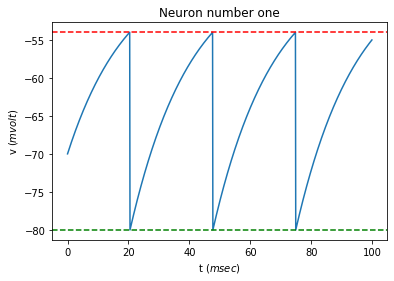

In [50]:
plt.plot(statemon.t/br.ms, statemon.v[0]*1000)
plt.xlabel('t ($msec$)')
plt.ylabel('v ($mvolt$)')
plt.title('Neuron number one')
plt.axhline(V_threshold/br.mvolt,ls = '--',c='red')
plt.axhline(V_reset/br.mvolt,ls = '--',c='green')



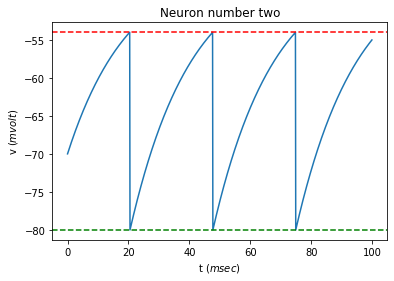

In [51]:
plt.plot(statemon.t/br.ms, statemon.v[1]*1000)
plt.xlabel('t ($msec$)')
plt.ylabel('v ($mvolt$)')
plt.title('Neuron number two')
plt.axhline(V_threshold/br.mvolt,ls = '--',c='red')
plt.axhline(V_reset/br.mvolt,ls = '--',c='green')




## Neural Models with Spikes


$\dfrac{\partial V}{\partial t} = (I_e R_m - (V-E_l) - g_s(t)(V-E_s)r_m)/\tau_m$

in which:

$I_e R_m = 25 mV$

$E_l = -70 mV $

$\tau_m = 20 ms$

$V_threshold = -54 mV$

$r_m = 10 M \Omega$


$\tau_m = 20 ms$

$E_s = 0 mV $(excitatory)

$E_s = -80 mV $(inhibitory)



In [390]:
def run_simulation(Es, tau_s, v0_1, v0_2):
    br.start_scope()

    # Parameters of the simulation

    tau_m = 20 * br.ms
    IR = 25*br.mvolt
    El = -70*br.mvolt
    N = 2
    V_threshold = -54*br.mvolt
    V_reset = -80*br.mvolt
    #Es = 0*br.mvolt
    #Es = -80*br.mvolt
    rm = 10*br.Mohm
    #tau_s = 10*br.ms

    equ = '''
    dv/dt =(IR - (v-El) - g*(v-Es)*rm)/tau_m : volt
    dg/dt = -g/tau_s : siemens
    '''

    G = br.NeuronGroup(N, equ, threshold = 'v>V_threshold',
                      reset = 'v = V_reset',method='euler')

    #G.v = El
    G.v = [[v0_1, v0_2],[v0_1, v0_1]][Es/br.mvolt<-40]
    
    ### Synapses

    synapse_equ ='''
    w : siemens
    '''

    on_pre_equ = '''
    g_post += w
    '''


    S = br.Synapses(G,G,synapse_equ,
                   on_pre=on_pre_equ,
                   delay=5*br.ms)
    S.connect(j='i')
    S.w = 5*br.nsiemens


    statemon = br.StateMonitor(G, ['v','g'], record = True)
    spikemon = br.SpikeMonitor(G)

    br.run(100*br.ms)
    
    
    return statemon, spikemon

In [398]:
def plotter(statemon, spikemon, delay,Es):

    spikes_time_1 = spikemon.t[spikemon.i==0]
    spikes_time_2 = spikemon.t[spikemon.i==1]
    fig = plt.figure(figsize= (14, 9))
    #delay = 5


    ax = fig.add_subplot(4,1,1)
    if Es > -10:
        ax.set_title('$E_s = {} mvolt$\nExcitatory synapse'.format(Es*1000), size=20)
    if Es <-40:
        ax.set_title('$E_s = {} mvolt$\nInhibitory synapse'.format(Es), size=20)

    ax.plot(statemon.t/br.ms, statemon.v[0]*1000)
    for elem in spikes_time_1:
        ax.axvline(elem/br.ms, c='orange', ls='--', lw=5)
    ax.set_ylabel('$v_1(mv)$', size=20)



    ax = fig.add_subplot(4,1,2)
    ax.plot(statemon.t/br.ms, statemon.v[1]*1000)
    for elem in spikes_time_2:
        ax.axvline(elem/br.ms, c='green', ls='--', lw=5)
    ax.set_ylabel('$v_2(mv)$', size=20)


    ax = fig.add_subplot(4,1,3)
    ax.plot(statemon.t/br.ms, statemon.g[0]*1e9)
    for elem in spikes_time_1:
        ax.axvline(elem/br.ms + delay, c='orange', ls='--', lw=5)
    ax.set_ylabel('$g_1(n\Omega^{-1})$', size=20)

    ax = fig.add_subplot(4,1,4)
    ax.plot(statemon.t/br.ms, statemon.g[1]*1e9)
    for elem in spikes_time_2:
        ax.axvline(elem/br.ms + delay, c='green', ls='--', lw=5)
    ax.set_ylabel('$g_2(n\Omega^{-1})$', size=20)
    ax.set_xlabel('t', size=20)
    
    

## Excitatory

In [399]:
Es = 0*br.mvolt
tau_s = 10*br.ms
v0_1 = v0_1=-80*br.mvolt
v0_2 = v0_2=-60*br.mvolt
statemon, spikemon = run_simulation(Es, tau_s, v0_1, v0_2 )

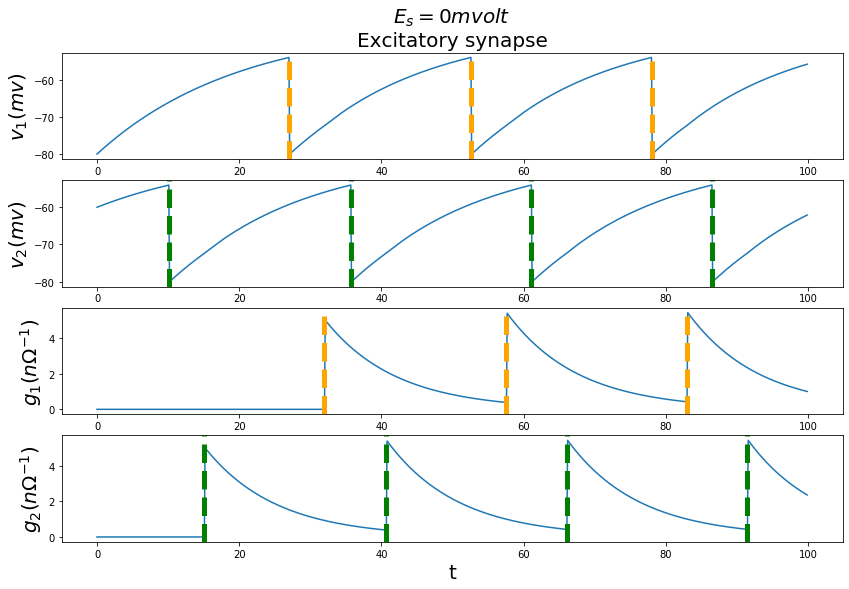

In [400]:
plotter(statemon, spikemon, 5, 0)

## Decreasing the $\tau_s$

In [401]:
Es = 0*br.mvolt
tau_s = 10*br.ms / 4
v0_1 = v0_1=-80*br.mvolt
v0_2 = v0_2=-60*br.mvolt
statemon, spikemon = run_simulation(Es, tau_s, v0_1, v0_2 )

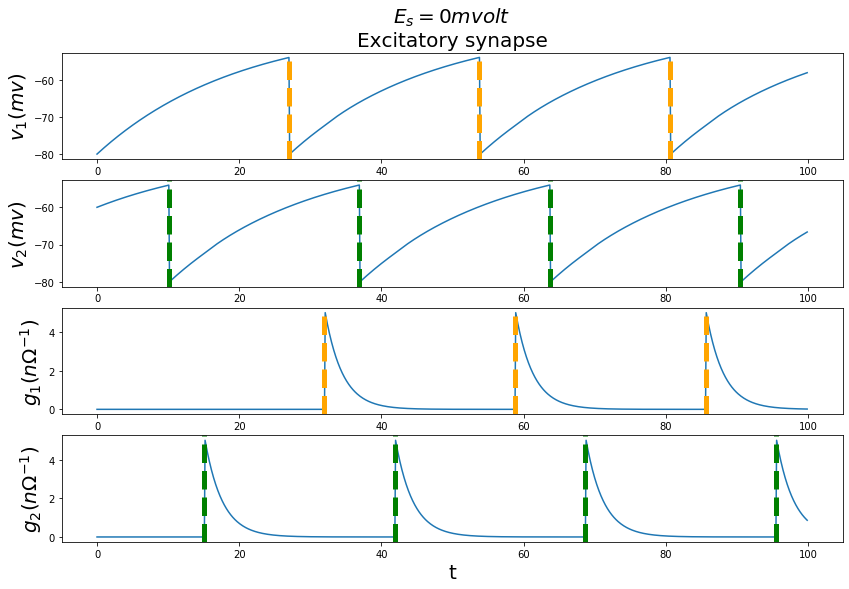

In [402]:
plotter(statemon, spikemon, 5, 0)

## Inhibitory Synapse

In [403]:
Es = -80*br.mvolt
tau_s = 10*br.ms
v0_1 = v0_1=-80*br.mvolt
v0_2 = v0_2=-60*br.mvolt
statemon, spikemon = run_simulation(Es, tau_s, v0_1, v0_2 )

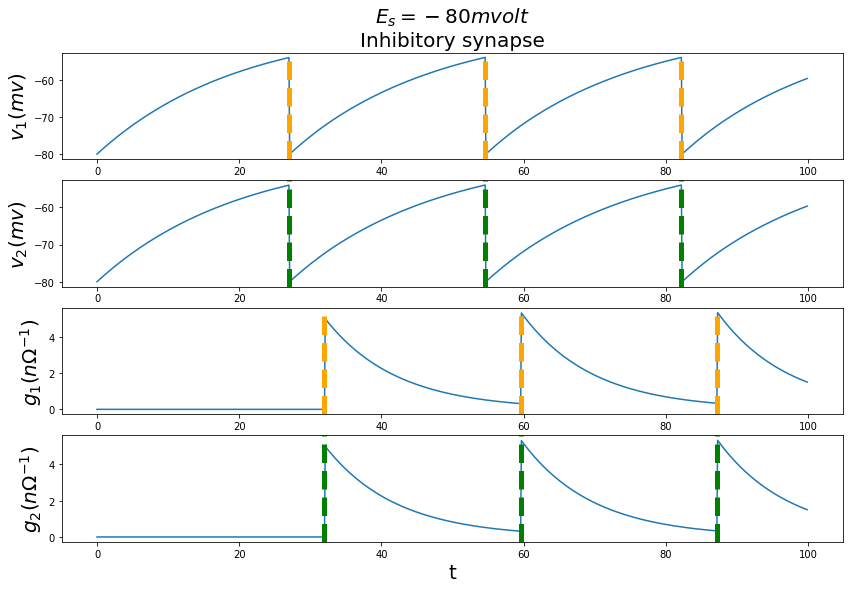

In [404]:
plotter(statemon, spikemon, 5, -80)